In [1]:
import matplotlib.pyplot as plt

import numpy as np
import tushare as ts
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D  #绘制三D图形

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [274]:
# 获取股票基本信息，包括 PE、PB 值
ts.set_token('42731ca565c5d019007ef5cd7db7808757b2ea3fdbfb31d4f7b61444b')
pro = ts.pro_api()

df_base = pro.stock_basic() # ts.get_stock_basics()
# df_base['code'] = df_base.index

# 获取股票当天数据，包括当前股价
df_todays = ts.get_today_all()
# df_todays['code'] = df_todays.index

df_roe = ts.get_report_data(2021, 3)
# df_roe['code'] = df_roe.index

[Getting data:]#################################################本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
[Getting data:]############################################################################

In [ ]:
# df = pro.daily_basic(ts_code='', trade_date='20211116')

In [275]:
df_base['code'] = df_base['ts_code'].str.slice(stop=-3)
df_roe = df_roe.drop_duplicates()

In [276]:
# 整合股价与 PE、PB 数据
df = pd.merge(df_todays, df_base, how='left', on=['code'])
df = pd.merge(df, df_roe, how='left', on=['code'])

# df.dropna()
result = df[(0 < df['pb']) 
            & (df['pb'] < 8)
            & (-20 < df['roe']) 
            & (df['roe'] < 30) 
            & (0 < df['trade']) 
            & (df['trade'] < 70)
            & (-100<df['per']) 
            & (df['per']<200)]

# result = df[(-100<df['per']) & (df['per']<200) 
#             &(0<df['pb_x'])&(df['pb_x']<10)
#              # &(roe_describe['25%']<df['roe'])&(df['roe']<roe_describe['75%'])
#              &(0<df['trade'])&(df['trade']<100)]

# X = result[['pb', 'roe', 'trade', 'code', 'industry', 'market']]

In [230]:
# hasher = FeatureHasher(input_type='string')
# c = hasher.transform(result['name'])

# vec = DictVectorizer()
# vec.fit_transform(result['name'].values).toarray()

# vectorizer = CountVectorizer()
# vectors = vectorizer.fit_transform(result['name']).toarrayay()

# freq   = CountVectorizer()
# onehot = Binarizer()
# corpus = onehot.fit_transform(freq.fit_transform(result['name']).toarray())

# tfidf  = TfidfVectorizer()
# corpus = tfidf.fit_transform(result['industry'])

In [2]:
result = pd.read_pickle('d:/d.pkl')

In [3]:
columns = ['pb', 'roe', 'trade']# ['pb', 'roe', 'per'] # ['pb', 'roe', 'trade']

In [4]:
scaler = MinMaxScaler()
scaler.fit(result[columns])
X = pd.DataFrame(scaler.transform(result[columns]), columns=columns)

In [5]:
# kmeans = KMeans(n_clusters=10)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

model = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', assign_labels='kmeans')
# model = DBSCAN(eps=0.6, min_samples=10)
# model = AffinityPropagation(random_state=5)
y_kmeans = model.fit_predict(X[columns])

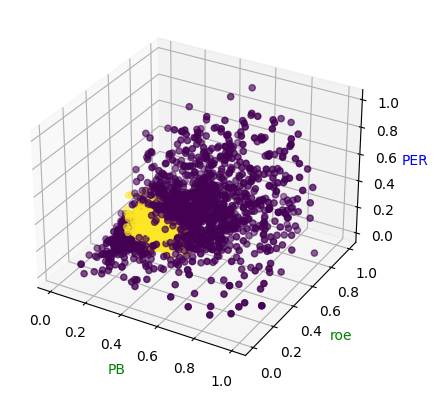

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X = result['pb'].tolist() # X 轴为 PB 数据 
# Y = result['roe'].tolist()
# Z = result['trade'].tolist() # Z 轴为 股价数据 

ax.set_xlabel('PB', color='g')
ax.set_ylabel('roe', color='g')
# ax.set_zlabel('trade', color='b') # 给三个坐标轴注明
ax.set_zlabel('PER', color='b') # 给三个坐标轴注明

ax.scatter(X['pb'], X['roe'], X['trade'], c=y_kmeans==0)
# ax.scatter(X['pb'], X['roe'], X['per'], c=y_kmeans)

plt.show()

In [271]:
result[y_kmeans == 0]

,code,name_x,changepercent,trade,open,high,low,settlement,volume,turnoverratio,...,name,eps,eps_yoy,bvps,roe,epcf,net_profits,profits_yoy,distrib,report_date
421,688009,中国通号,1.010,5.00,4.94,5.00,4.94,4.95,9828594,0.48739,...,中国通号,0.22,-8.33,NaN,5.57,NaN,240921.59,-9.16,NaN,10-28
559,603980,吉华集团,0.820,6.15,6.12,6.18,6.07,6.10,3896600,0.55666,...,吉华集团,0.21,0.00,NaN,3.35,NaN,14953.64,3.78,NaN,10-27
601,603900,莱绅通灵,0.870,6.96,6.88,7.01,6.85,6.90,1396920,0.41029,...,莱绅通灵,0.30,9.92,NaN,4.38,NaN,10220.95,9.91,NaN,10-30
611,603887,城地香江,2.561,7.61,7.41,7.64,7.39,7.42,3955355,1.11749,...,城地香江,0.15,-80.00,NaN,1.65,NaN,6736.12,-76.24,NaN,10-28
635,603843,正平股份,1.809,3.94,3.88,3.95,3.85,3.87,4736802,0.84585,...,正平股份,0.11,10.00,NaN,4.02,NaN,6516.04,18.34,NaN,10-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4580,000055,方大集团,2.893,4.98,4.86,5.10,4.86,4.84,32850921,4.84946,...,方大集团,0.16,-20.00,NaN,3.22,NaN,17702.83,-17.90,NaN,10-30
4586,000042,中洲控股,0.140,7.17,7.18,7.19,7.12,7.16,789918,0.11897,...,中洲控股,0.50,238.82,NaN,4.15,NaN,33249.84,238.88,NaN,10-27
4592,000035,中国天楹,1.954,5.74,6.02,6.02,5.67,5.63,94452286,3.84994,...,中国天楹,0.22,12.35,NaN,4.59,NaN,53939.56,8.64,NaN,10-27
4685,600387,ST海越,0.000,4.86,4.85,4.87,4.84,4.86,1521600,0.37659,...,ST海越,0.04,-63.64,NaN,0.57,NaN,1808.45,-66.14,NaN,10-30


In [236]:
result.ts_code

75      688981.SH
76      688819.SH
85      688779.SH
97      688722.SH
100     688707.SH
          ...    
4701    600242.SH
4707    600217.SH
4712    600163.SH
4713    600146.SH
4719    600091.SH
Name: ts_code, Length: 2528, dtype: object

In [254]:
result[result['code'] == '000001']['roe']

4619    8.86
Name: roe, dtype: float64

In [250]:
result.columns

Index(['code', 'name_x', 'changepercent', 'trade', 'open', 'high', 'low',
       'settlement', 'volume', 'turnoverratio', 'amount', 'per', 'pb',
       'mktcap', 'nmc', 'ts_code', 'symbol', 'name_y', 'area', 'industry',
       'market', 'list_date', 'name', 'eps', 'eps_yoy', 'bvps', 'roe', 'epcf',
       'net_profits', 'profits_yoy', 'distrib', 'report_date'],
      dtype='object')

In [ ]:
result = pd.read_pickle('d:/d.pkl')